In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
%matplotlib qt
%matplotlib inline

ImportError: /opt/ros/kinetic/lib/python2.7/dist-packages/cv2.so: undefined symbol: PyCObject_Type

In [ ]:
def camera_calibration():
    # read an dmake a list of calibration images 
    images = glob.glob("camera_cal/calibration*.jpg")

    # Array to store object points and image points
    objpoints = []    # 3D point of real world space
    imgpoints = []    # 2D point of image 
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    # The .T transposes the matrix, and the .reshape(-1,2) then reshapes it into a two-column array shape
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 
    
    for image in images:
        img = cv2.imread(image)
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corner are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx, dist = camera_calibration()
print ('mtx: ', mtx)
print ('dist: ', dist)

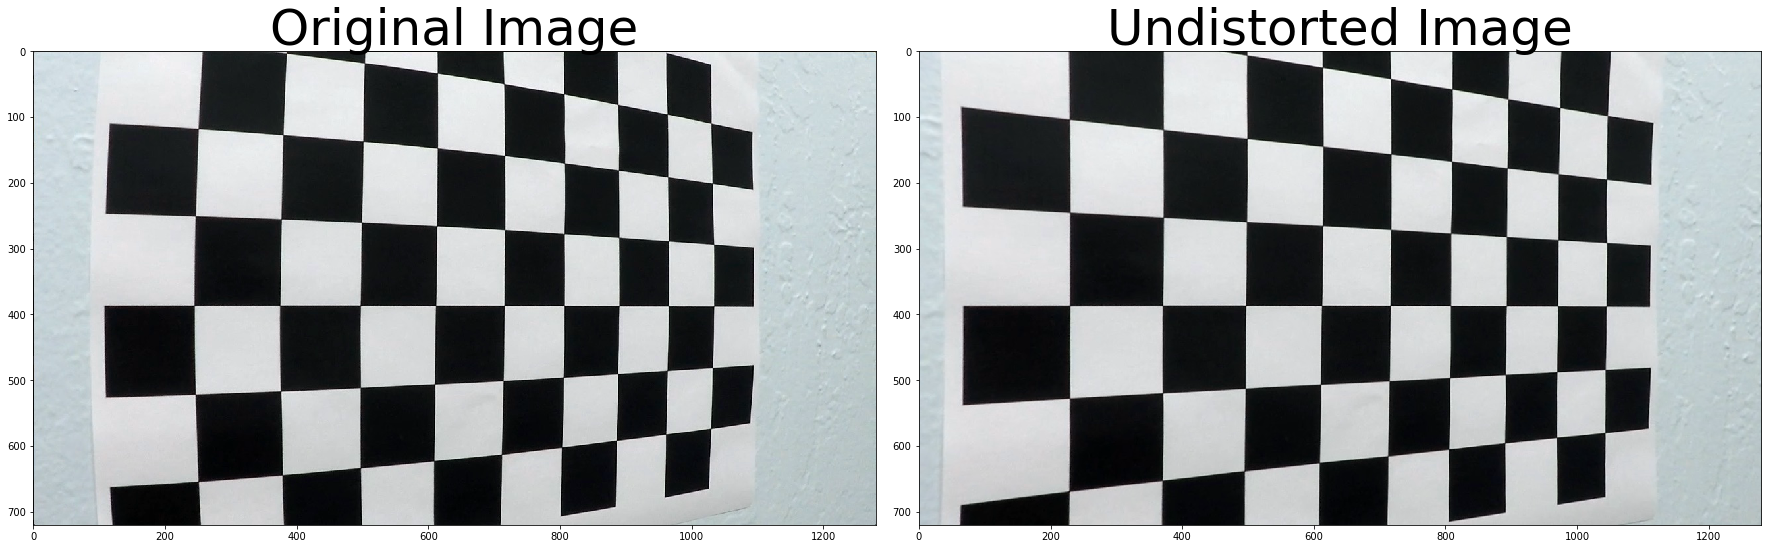

In [27]:
def cal_undistort(img, mtx, dist):
#     Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

img = cv2.imread('camera_cal/calibration5.jpg')
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    

In [ ]:
def thresholded_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):

#     Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    l_channel = hls[:,:,1]    # Separate l Channel
    s_channel = hls[:,:,2]    # Separate s Channel
    
#     Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
#     Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
#     Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

img = mpimg.imread('test_images/test5.jpg')
undistorted = cal_undistort(img, mtx, dist)
color_binary, combined_binary = thresholded_binary_image(undistorted)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(color_binary)
ax2.set_title('Stacked thresholds', fontsize=20)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined S channel and gradient thresholds', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4)-100, 0],
    [(img_size[0] / 4)-100, img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
#     Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
#     Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

M, Minv, binary_warped = perspective_transform(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#     take a histogram along all the columns in the lower half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
plt.plot(histogram)

In [ ]:
def find_lane_pixels(binary_warped, view):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
#     Find the peak of the left and right halves of the histogram
#     These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
       
#     Hyperparameters
    nwindows = 9   # number of windows
    margin = 100   # set the width of window +/- margin
    minpix = 50    # minimum number of pixels in window
    
    #     Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
#     Identify the x and y position of all the nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
#     current position of each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
#     Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
#     Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If > minpix found  pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    #Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
#     View your output
    if (view == True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.set_title('Sliding Window', fontsize=50)
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#   View your output
    if (view == True):
        ax2.set_title('Search from prior', fontsize=50)
        ax2.imshow(result)
        ax2.plot(right_fitx, ploty, color='yellow')
        ax2.plot(left_fitx, ploty, color='yellow')
    
    return result, out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = find_lane_pixels(binary_warped, True)
